In [330]:
import datetime as dt
from datetime import datetime, timedelta
import re
import time
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import requests
import pymorphy2

# Сбор данных

In [4]:
# Функция для получения данных по запросу
def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

In [15]:
vk_token = 'vk1.a.x4es-Rmk_rd-hZQFvaOMqH39bUHjtZ54EQPKft4QVYAcCSB47JdGfiYV-hfiTsHAztfRIEbff258sbCmaceWaGKtiCBdjgSU9LGpmrrHInN_m_H8bb2hoHWnZT1mOK80Tl4Jz-BskzbFGjHXWhV-WCj0YaF2uiTNk5uS9ihTUOHnONbQI1ogIpnrxuA-w2au'
offset = 0 # Переменная, отвечающая за сдвиг в запросе
days = 0
responses = [] # Список, в котором будут храниться данные по всем запросам
# Собираем все данные публикаций за последний год
while days<365:
    try:
        url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&offset='+ str(offset)+ '&owner_id=-66669811&count=1&v=5.92'
        response = getjson(url)
        days = (datetime.now() - datetime.fromtimestamp(response['response']['items'][0]['date'])).days
        responses.append(response)
        offset+=1
        # Было выявлено, что после 8 непрерывных запросов начинают происходить ошибки при попытке получения данных запроса.
        # Поэтому было принято решение искусственно увеличить время между запросами. Как следствие, время для сбора необходимых данных кратно увеличилось.
        time.sleep(0.2) # Оптимальное время между запросами, предотвращающее появление ошибки
    except:
        offset+=1
print('end')

end


In [16]:
len(responses)

433

In [62]:
# Списки, содержащие определенный набор данных
likes = []
views = []
comments = []
date = []
text = []
text_len = []
reposts = []
hash_tags = []
post_id = []
votes = []
attachments = []

expr = r'#\w+' # Регулярное выражение для поиска хештегов

for j in range(len(responses)):
    # Общую часть запроса к json словарю определим переменной
    main_dict = responses[j]['response']['items'][0]
    # Список id постов
    post_id.append(main_dict['id'])
    # Список количества репостов
    reposts.append(main_dict['reposts']['count'])
    # Список текстов постов
    text.append(main_dict['text'])
    # Список длины текстов постов
    text_len.append(len(main_dict['text']))
    # Список количества лайков
    likes.append(main_dict['likes']['count'])
    # Список количества просмотров постов
    views.append(main_dict['views']['count'])
    # Список количества комментариев
    comments.append(main_dict['comments']['count'])
    # Находим хэштеги
    tags = re.findall(expr, main_dict['text'])
    # Список преобразованных хэштегов
    hash_tags.append(list(map(lambda x: x[1:].lower().replace('_', ' ').replace('skillbox', '').strip(),tags)))
    # Список преобразованных дат
    date.append((datetime.fromtimestamp(main_dict['date']) - timedelta(hours=0)))
    # Список типов медиавложений в посте
    attachments.append(list(set([x['type'] for x in main_dict['attachments']])))
    # Список голосов в постах с прикрепленным голосованием
    try:
        votes.append(main_dict['attachments'][1]['poll']['votes'])
    except:
        votes.append(None)

# Создаем пустой датафрейм
data = pd.DataFrame()

# Наполняем датафрейм полученными списками
data['id'] = post_id
data['likes'] = likes
data['views'] = views
data['reposts'] = reposts
data['comments'] = comments
data['date'] = date
data['text'] = text
data['text_len'] = text_len
data['tags'] = hash_tags
data['votes'] = votes
data['attachments'] = attachments

data

,id,likes,views,reposts,comments,date,text,text_len,tags,votes,attachments
0,290988,19,13484,6,0,2023-07-03 14:21:15,Как приручить нейросети?\n\nРасскажем на больш...,427,[],NaN,[video]
1,291191,4,4989,1,0,2023-07-07 17:36:19,"Представьте: вам поставили задачу, дедлайн — д...",143,[],NaN,[poll]
2,291182,7,6708,1,0,2023-07-07 12:00:02,А как мама будет рада!\n\nИ мы тоже порадуемся...,85,[],NaN,[photo]
3,291171,7,6901,7,0,2023-07-06 17:34:56,"🎮 Мечтаете создавать игры?\n\nЗначит, пора опр...",182,[],NaN,[photo]
4,291154,5,10104,0,0,2023-07-06 14:02:07,"Одних вдохновляют фильмы, музыка, книги.\nА др...",445,[],NaN,[photo]
...,...,...,...,...,...,...,...,...,...,...,...
428,250916,25,20115,19,6,2022-07-11 13:11:20,"Погрузиться в DevOps, научиться превращать рис...",405,[расписание],NaN,[photo]
429,250901,77,29894,94,0,2022-07-11 10:23:04,"Сегодня разберемся, как работать с «Яндекс.Мет...",322,[маркетинг],NaN,[photo]
430,250813,9,12666,5,0,2022-07-08 13:53:54,Реально ли сменить профессию за год?\n\nА поче...,341,[дизайн],NaN,[video]
431,250746,18,12659,18,0,2022-07-08 10:30:17,Вот и наступили собачьи дни лета!\n\nЗвучит ст...,338,[],NaN,[photo]


# Нахождение рубрик по хештегам

In [249]:
# Расширяем датафрейм, раскрывая списки тегов
data_tags = data.explode('tags')

In [331]:
# Создаем словрь с наименованиями всех тегов и их количеством в постах
tags_dict = {}
for i in data_tags.tags:
    if i in tags_dict:
        tags_dict[i] += 1
    else:
        tags_dict[i] = 1
tags_dict

{nan: 269,
 'киноимузыка': 24,
 'дайджестпочетвергам': 5,
 'жизньпосле': 5,
 'лояльность': 3,
 'дизайнтожеit': 3,
 'программирование': 16,
 'знаниялучшийподарок': 3,
 'психология': 9,
 'игры': 11,
 'дизайн': 49,
 'общееразвитие': 1,
 'skillсемплинг дизайн': 1,
 'skillсемплинг easy': 1,
 'высшее образование': 5,
 'маркетинг': 10,
 'управление': 6,
 'skilbox игры': 1,
 'неткибербуллингу': 1,
 'безкорочки': 1,
 'skilbox программирование': 1,
 'деньдцп': 1,
 'деньучителя': 1,
 'деньпрограммиста': 1,
 'расписание': 6,
 'деньшахмат': 1}

Видим, что у большей части постов отсутствуют теги, что усложнит анализ постов по рубрикам

In [333]:
# Преобразуем словарь тегов в датафрейм и уберем из рассмотрения отсутствующие теги
tags_df = pd.DataFrame(tags_dict.items(), columns=['tags', 'count'])
tags_df.sort_values(by= 'count',ascending=False ,inplace=True)
tags_df.dropna(inplace=True)
tags_df

,tags,count
10,дизайн,49
1,киноимузыка,24
6,программирование,16
9,игры,11
15,маркетинг,10
8,психология,9
24,расписание,6
16,управление,6
3,жизньпосле,5
2,дайджестпочетвергам,5


In [334]:
tags_list=list(tags_df.tags.values)
tags_list

['дизайн',
 'киноимузыка',
 'программирование',
 'игры',
 'маркетинг',
 'психология',
 'расписание',
 'управление',
 'жизньпосле',
 'дайджестпочетвергам',
 'высшее образование',
 'дизайнтожеit',
 'лояльность',
 'знаниялучшийподарок',
 'skilbox программирование',
 'деньпрограммиста',
 'деньучителя',
 'деньдцп',
 'skillсемплинг easy',
 'безкорочки',
 'неткибербуллингу',
 'skilbox игры',
 'skillсемплинг дизайн',
 'общееразвитие',
 'деньшахмат']

In [335]:
# Создаем словарь с рубриками, в котором будут содержаться именования тегов. 
# Также дополним этот словарь некоторыми ключевыми словами, что может понадобится в дальнейшем для анализа рубрик по ключевым словам поста

dict_of_rubr = {
    'Образование':['курс', 'проект','skillbox_высшее_образование', 'обучение','образование','высшее образование'],
    'Карьера':['профессия', 'работа', 'возможность', 'карьера', 'вакансия','бизнес','фриланс','удалёнка','рынок'],
    'Особые даты и мероприятия': ['день','календарь','вебинар','интенсив','январь','февраль','март','апрель',
                                  'май','июнь','июль','август','сентябрь','октябрь','ноябрь','декабрь','расписание'],
    'Истории людей':['сергей','елена','дмитрий','александр','павел', 'виктория','николай','игорь','георгий','юлия','алексей','ксения','константин',
             'настя','наталья','александра','альберт', 'анастасия','карточка'],
    'Дизайн':['skillbox_дизайн','дизайн','дизайнер','бренд','дизайнтожеit'],
    'Программирование':['skillbox_программирование','skilbox программирование','программирование','нейросеть','программа','аналитик','аналитика','айтишник'],
    'Психология':['skillbox_психология','психология','тревога','буллинг','депрессия'],
    'Маркетинг':['skillbox_маркетинг','маркетинг'],
    'Управление':['skillbox_управление','управление','менеджер'],
    'Кино и музыка':[ 'skillbox_киноимузыка','киноимузыка','кино','фильм','сериал','музыка'],
    'Игра':['skillbox_игра','skilbox_игра','игра']
    
}

In [336]:
# Список наименований составленных рубрик
rubrics = list(dict_of_rubr.keys())
rubrics

['Образование',
 'Карьера',
 'Особые даты и мероприятия',
 'Истории людей',
 'Дизайн',
 'Программирование',
 'Психология',
 'Маркетинг',
 'Управление',
 'Кино и музыка',
 'Игра']

In [337]:
# Преобразуем словарь с рубриками к удобному для работы виду

lists_of_rubr =[[(i, j) for j in dict_of_rubr[i]] for i in dict_of_rubr]

flatten_genres = list(itertools.chain(*lists_of_rubr))

rubr_df = pd.DataFrame(flatten_genres, columns = ['rubric', 'word'])
rubr_df

,rubric,word
0,Образование,курс
1,Образование,проект
2,Образование,skillbox_высшее_образование
3,Образование,обучение
4,Образование,образование
...,...,...
78,Кино и музыка,сериал
79,Кино и музыка,музыка
80,Игра,skillbox_игра
81,Игра,skilbox_игра


In [261]:
# Функция для подбора рубрики для постов по слову

def equality(x, df):
    list_new = []
    for i in x:      
        if i in list(df.word):
            list_new.append(df.set_index('word').loc[i,:].values[0])                   
        else:
            list_new.append('Без рубрики')
    return list_new

In [263]:
# Применяем функию по подбору рубрик по хештегу к нашему датафрейму
data_tags['rubr_tags'] = equality(data_tags.tags, rubr_df)
# Создаем новый датафрейм со средними значениями данных по метрикам активности пользователей для каждой рубрики
data_avg = data_tags[['rubr_tags', 'likes', 'views', 'reposts', 'comments', 'votes']]\
    .groupby('rubr_tags')\
    .agg('mean')
data_avg

,likes,views,reposts,comments,votes
rubr_tags,,,,,
Без рубрики,38.990385,23870.743590,17.721154,23.564103,433.2
Дизайн,35.807692,23027.096154,14.346154,3.076923,NaN
Кино и музыка,29.250000,23422.875000,10.291667,3.916667,NaN
Маркетинг,42.500000,24226.500000,28.100000,1.600000,NaN
Образование,27.800000,25447.200000,18.400000,0.000000,NaN
Программирование,32.823529,25377.000000,17.705882,4.529412,NaN
Психология,32.333333,18881.888889,20.666667,3.555556,NaN
Управление,60.000000,34058.500000,45.166667,7.666667,NaN


In [338]:
# Удельные показатели активности пользователей на 1000 просмотров для каждого поста

data_spec = data_avg[['likes','comments','reposts']].div(data_avg['views'], axis=0)*1000
data_spec

,likes,comments,reposts
rubr_key_word,,,
Без рубрики,1.628358,0.897921,0.722175
Дизайн,1.557066,0.158722,0.712095
Игра,1.808531,0.188424,1.054836
Истории людей,1.449515,0.326457,0.779167
Карьера,1.351394,0.210900,0.790275
Кино и музыка,1.352704,0.165349,0.584122
Маркетинг,1.511077,0.057515,0.892355
Образование,2.172077,0.445884,0.726625
Особые даты и мероприятия,1.229519,1.504564,0.770046


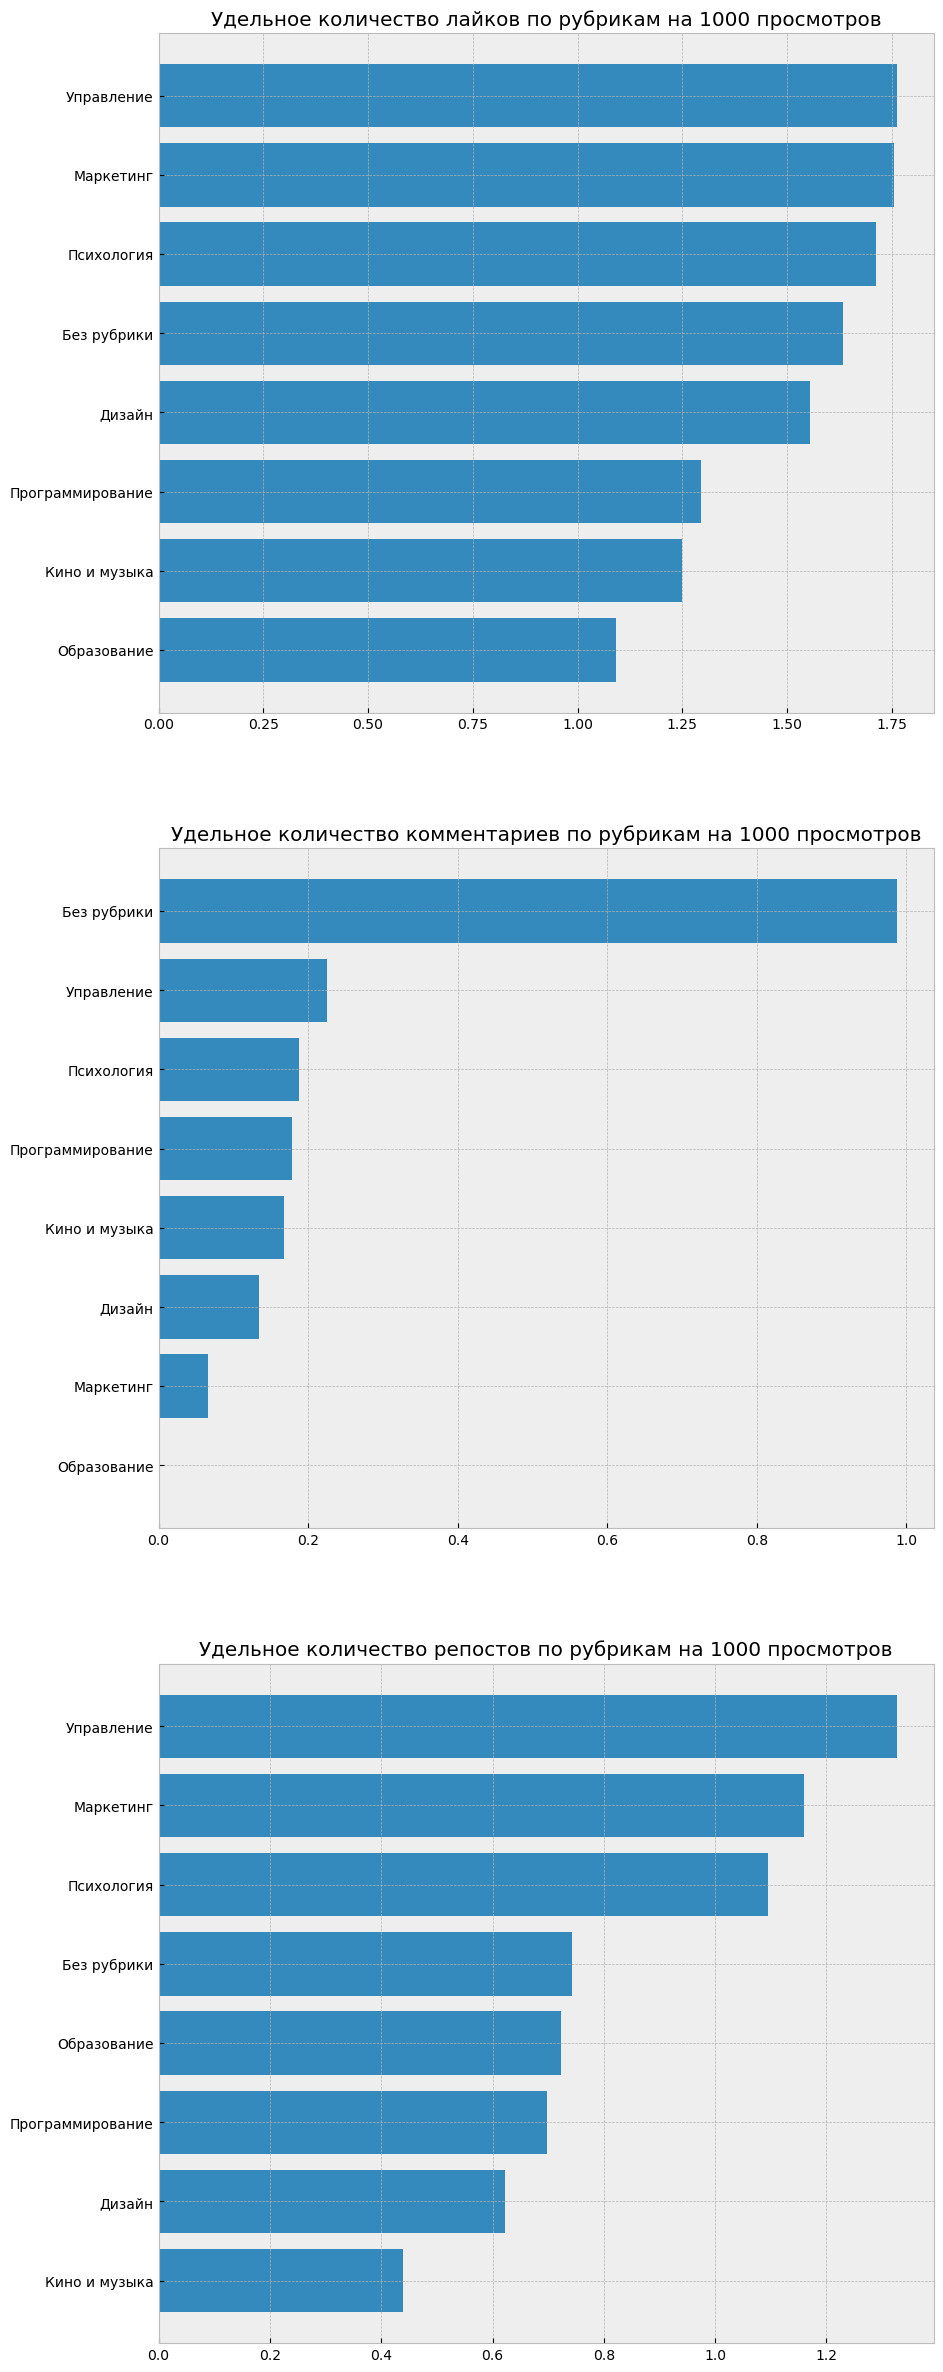

In [265]:
# Построим графики удельного количества лайков, комментариев и репостов для всех рубрик
plt.style.use('bmh')
fig = plt.figure(figsize=(10,30))
ax = fig.add_subplot(3,1,1)
ax.barh(data_spec.sort_values('likes',ascending=True).index, data_spec.sort_values('likes',ascending=True).likes)
ax.set_title('Удельное количество лайков по рубрикам на 1000 просмотров')
ax = fig.add_subplot(3,1,2)
ax.barh(data_spec.sort_values('comments',ascending=True).index, data_spec.sort_values('comments',ascending=True).comments)
ax.set_title('Удельное количество комментариев по рубрикам на 1000 просмотров')
ax = fig.add_subplot(3,1,3)
ax.barh(data_spec.sort_values('reposts',ascending=True).index, data_spec.sort_values('reposts',ascending=True).reposts)
ax.set_title('Удельное количество репостов по рубрикам на 1000 просмотров')
plt.show()

In [339]:
# Количество постов по рубрикам
data_tags['count'] = 1
data_tags[['rubr_tags', 'count']].groupby('rubr_tags').agg('sum')

,count
rubr_tags,
Без рубрики,312
Дизайн,52
Кино и музыка,24
Маркетинг,10
Образование,5
Программирование,17
Психология,9
Управление,6


# Вывод:

Из распределения хештегов по рубрикам следует, что
# 1.
### - __Наибольшее__ удельное количество __лайков__ собирают посты с рубриками:

* управление
* маркетинг
* психология

Такие рубрики обладают максимально полезной для людей специализированной информацией, связанной с их повсдедневными заботами.

### - __Наименьшее__ удельное количество __лайков__ собирают посты с рубриками:

* Образование
* Кино и музыка
* Программирование

Такие рубрики в основном несут общий информативный характер или трубуют обратную связь.

# 2.
### - __Наибольшее__ удельное количество __комментариев__ собирают посты с рубриками:

* не отнесено ни к одной рубрике
* управление
* психология


### - __Наименьшее__ удельное количество __комментариев__ собирают посты с рубриками:

* Образование
* Маркетинг
* Дизайн

Такие рубрики в основном несут общий информативный характер. Примечетельно, что рубрика 'маркетинг' собирает гораздо меньше комментариев, чем лайков.

# 3.
### - __Наибольшее__ удельное количество __репостов__ собирают посты с рубриками:

* управление
* маркетинг
* психология

Это повторяет распределение по количеству лайков.

### - __Наименьшее__ удельное количество __репостов__ собирают посты с рубриками:

* Кино и музыка
* Дизайн
* Программирование

Такие рубрики в основном несут общий информативный характер. 

## Нахождение рубрик по ключевым словам и хештегам в тексте поста

Так как многие посты не имеют тега, поэтому большую часть данных сложно соотнести с рубрикой. Поэтому была предпринята попытка 
охарактеризовать текст поста по 3 самым повторяющимся словам и на их основе отнести пост к рубрике.

In [266]:
def find_words_nouns(text):
    ''' Функция для поиска 3 самых популярных слов в тексте поста'''
    # регулярка для поиска слов
    regular_expr = r'\w+'
    reg_expr_compiled = re.compile(regular_expr)
    # приводим к нижнему регистру
    raw_text_lower = text.lower()
    # разбиваем текст на слова
    text_by_words = reg_expr_compiled.findall(raw_text_lower) 
    
    # Список с нормированными существительными
    normalized_corpus = []
    morph = pymorphy2.MorphAnalyzer()

    for word in text_by_words:
        parsed_token = morph.parse(word)
        normal_form = parsed_token[0].normal_form
        if morph.parse(normal_form)[0].tag.POS == 'NOUN':
            normalized_corpus.append(normal_form)
        else:
            pass
    
    # датафрейм для группировки и сортировки слов по популярности 
    tokens_df = pd.DataFrame({
        'word': normalized_corpus
    })

    tokens_df = tokens_df.assign(dummy = 1)
    
    tokens_df = tokens_df.groupby(['word'])['dummy'].count().reset_index().sort_values(by='dummy', ascending=False).head(3)
    
    key_words = list(tokens_df.word.values)
    
    return key_words
            
    

In [268]:
# Создаем столбец с 3 самыми популярными словами к посту
data['key_words'] = data['text'].apply(find_words_nouns)

In [277]:
# Добавляем к списку 3 самых полпулярных слов наименование хештега
data['key_words'] = data['key_words'] + data['tags']

In [282]:
data.head(20)

,id,likes,views,reposts,comments,date,text,text_len,tags,votes,attachments,rubr_tags,day_of_week,hour_post,key_words
0,290988,19,13484,6,0,2023-07-03 14:21:15,Как приручить нейросети?\n\nРасскажем на больш...,427,[],NaN,video,Без рубрики,Monday,14,"[нейросеть, будущее, время]"
1,291191,4,4989,1,0,2023-07-07 17:36:19,"Представьте: вам поставили задачу, дедлайн — д...",143,[],NaN,poll,Без рубрики,Friday,17,"[вариант, дедлайн, задача]"
2,291182,7,6708,1,0,2023-07-07 12:00:02,А как мама будет рада!\n\nИ мы тоже порадуемся...,85,[],NaN,photo,Без рубрики,Friday,12,"[виктория, мама, отзыв]"
3,291171,7,6901,7,0,2023-07-06 17:34:56,"🎮 Мечтаете создавать игры?\n\nЗначит, пора опр...",182,[],NaN,photo,Без рубрики,Thursday,17,"[геймдева, игра, карточка]"
4,291154,5,10104,0,0,2023-07-06 14:02:07,"Одних вдохновляют фильмы, музыка, книги.\nА др...",445,[],NaN,photo,Без рубрики,Thursday,14,"[работа, дизайн, проект]"
5,291130,30,17243,19,12,2023-07-05 18:16:19,Вашим дизайнерским проектам не хватает трендов...,167,[],NaN,photo,Без рубрики,Wednesday,18,"[гамма, карточка, минь]"
6,291115,60,26408,21,17,2023-07-05 14:54:04,Вакансия: у нас дружный коллектив.\nДружный ко...,318,[],NaN,photo,Без рубрики,Wednesday,14,"[вакансия, коллектив, мочь]"
7,291069,5,8223,3,0,2023-07-04 16:02:30,Как много больших профессий!\n\nА еще больше —...,289,[],NaN,photo,Без рубрики,Tuesday,16,"[возможность, город, информация]"
8,291043,13,8446,1,0,2023-07-04 12:00:12,Отказаться от хорошего заработка ради… дальней...,456,[киноимузыка],NaN,photo,Кино и музыка,Tuesday,12,"[skillbox_киноимузыка, оператор, съёмка, кинои..."
9,290889,22,9286,3,8,2023-06-30 16:00:00,Где дизайнеры ищут вдохновение?\n\nПоспрашивал...,99,[],NaN,video,Без рубрики,Friday,16,"[вдохновение, дизайн, дизайнер]"


In [283]:
data.loc[19,'text']

'«У меня была цель — скорее найти новую работу».\n\nАндрей выгорел в сфере продаж и захотел сменить профессию. Да так сильно, что прошел полугодовой курс «Профессия SEO-специалист» за 2 месяца.\n\nТеперь он — руководитель отдела SEO в крупном digital-агентстве Smirnov Marketing.\nЧитайте его историю в карточках!\n\nА сколько вам понадобится времени, чтобы пройти этот курс? https://vk.cc/coW6E3'

In [306]:
# Расщиряем датафейм раскрывая список ключевых слов
data_key_words = data.explode('key_words')


In [341]:
# Датафрейм для подсчета самых популярных слов во всех постах
df_words = data_key_words['key_words'].reset_index()
df_words['dummy'] = 1
df_words_count = df_words[['key_words','dummy']].groupby('key_words').count().reset_index()
df_words_count.sort_values(by='dummy', ascending=False ,inplace=True)
df_words_count

,key_words,dummy
203,дизайн,77
316,курс,58
425,профессия,49
190,день,47
4,skillbox_дизайн,33
...,...,...
227,жюри,1
224,женщина,1
223,желание,1
222,жара,1


In [342]:
# Применяем функию по подбору рубрик по слову к новому датафрейму
data_key_words['rubr_key_word'] = equality(data_key_words.key_words, rubr_df)
# Создаем новый датафрейм со средними значениями данных по метрикам активности пользователей для каждой рубрики
data_avg = data_key_words[['rubr_key_word', 'likes', 'views', 'reposts', 'comments', 'votes']]\
    .groupby('rubr_key_word')\
    .agg('mean')
data_avg

,likes,views,reposts,comments,votes
rubr_key_word,,,,,
Без рубрики,39.113956,24020.490397,17.346991,21.568502,428.083333
Дизайн,33.805755,21711.194245,15.460432,3.446043,666.000000
Игра,59.722222,33022.500000,34.833333,6.222222,NaN
Истории людей,36.530303,25201.742424,19.636364,8.227273,191.000000
Карьера,30.576087,22625.597826,17.880435,4.771739,NaN
Кино и музыка,30.716981,22707.830189,13.264151,3.754717,NaN
Маркетинг,37.695652,24946.217391,22.260870,1.434783,NaN
Образование,53.806818,24772.056818,18.000000,11.045455,504.000000
Особые даты и мероприятия,27.500000,22366.473214,17.223214,33.651786,NaN


In [343]:
# Удельные показатели активности пользователей

data_spec = data_avg[['likes','comments','reposts']].div(data_avg['views'], axis=0)*1000
data_spec.reset_index()

,rubr_key_word,likes,comments,reposts
0,Без рубрики,1.628358,0.897921,0.722175
1,Дизайн,1.557066,0.158722,0.712095
2,Игра,1.808531,0.188424,1.054836
3,Истории людей,1.449515,0.326457,0.779167
4,Карьера,1.351394,0.210900,0.790275
5,Кино и музыка,1.352704,0.165349,0.584122
6,Маркетинг,1.511077,0.057515,0.892355
7,Образование,2.172077,0.445884,0.726625
8,Особые даты и мероприятия,1.229519,1.504564,0.770046
9,Программирование,1.320092,0.246891,0.772559


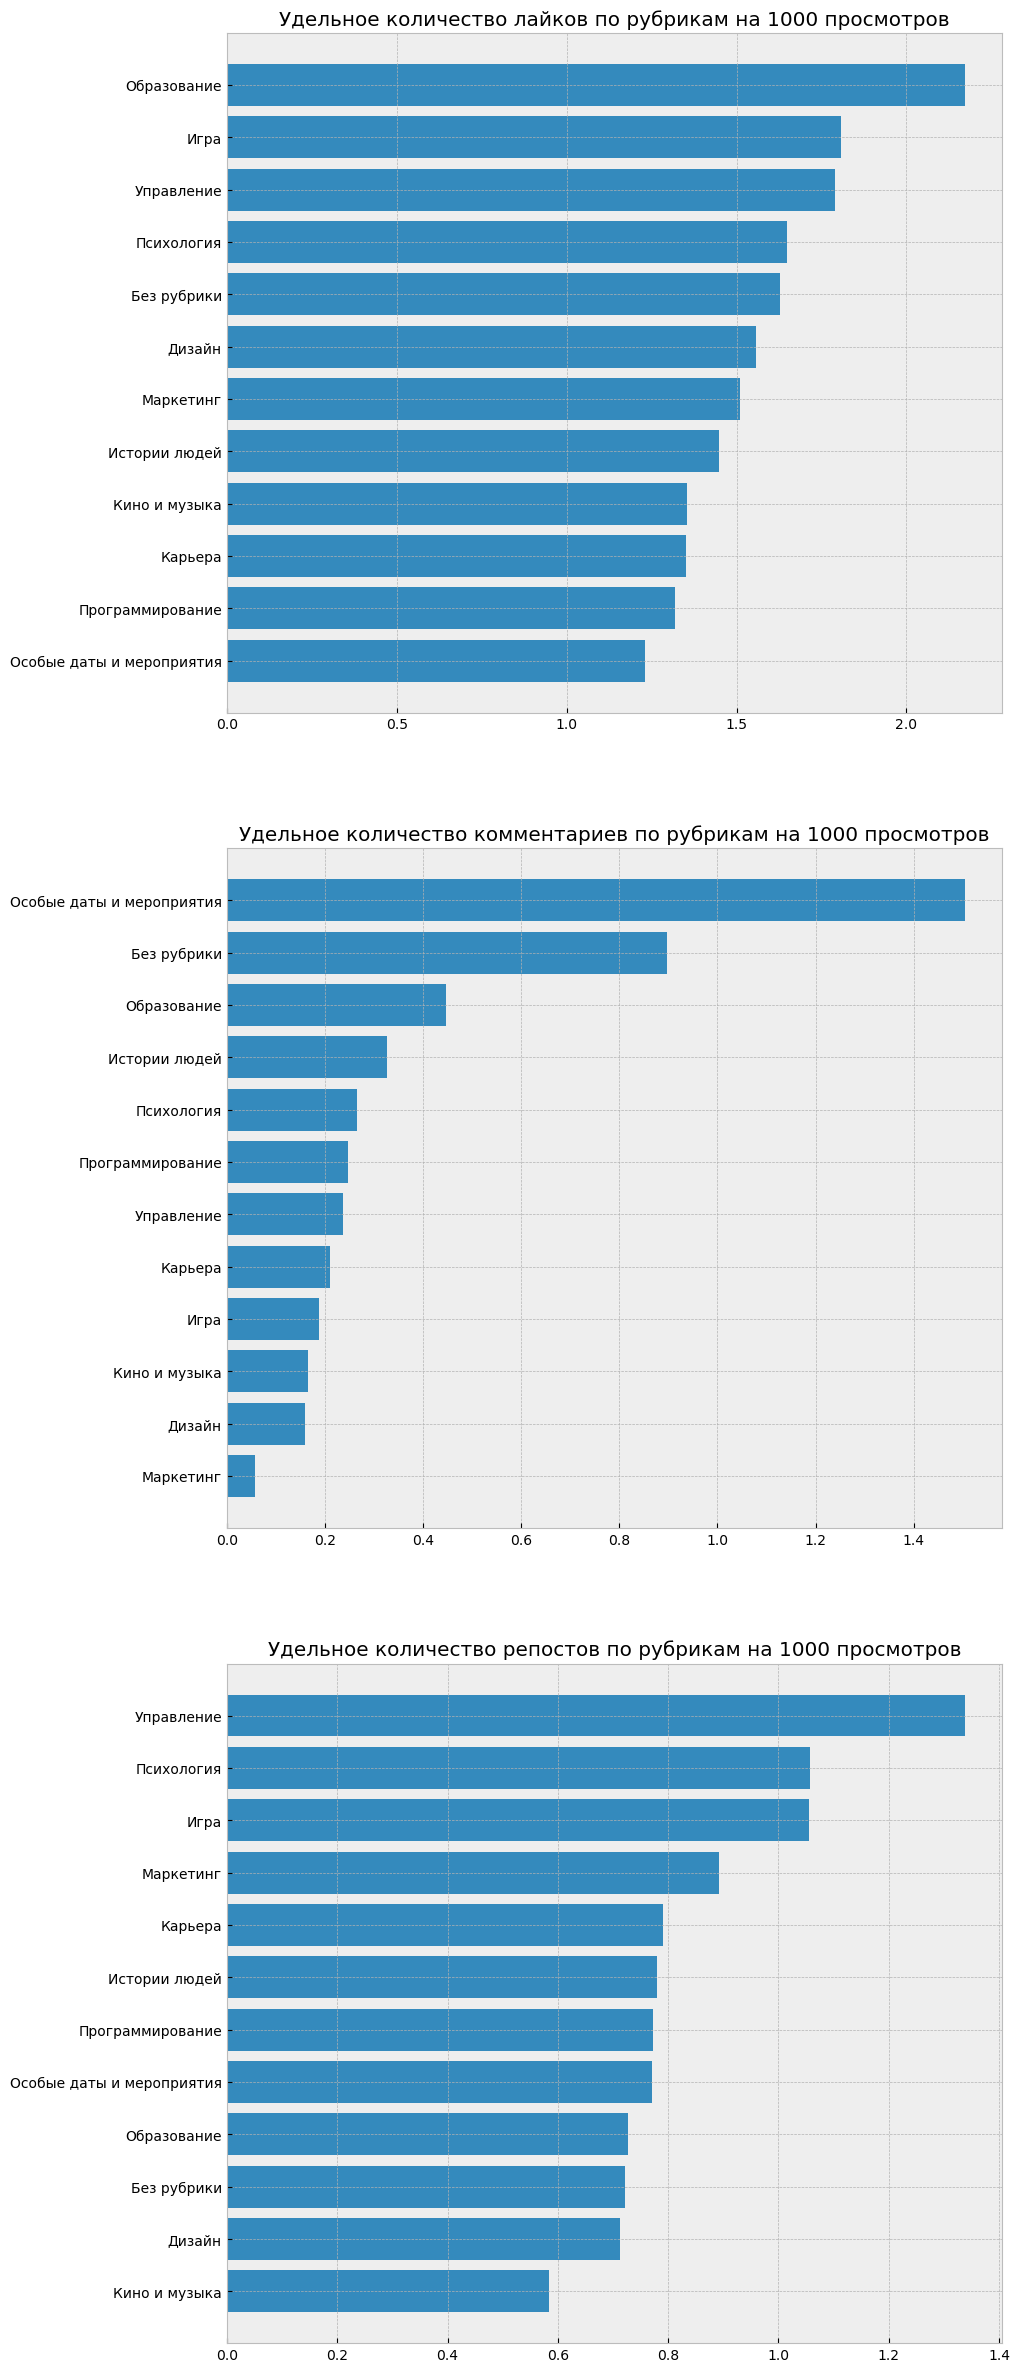

In [344]:
# Построим графики удельного количества лайков, комментариев и репостов для всех рубрик
plt.style.use('bmh')
fig = plt.figure(figsize=(10,30))
ax = fig.add_subplot(3,1,1)
ax.barh(data_spec.sort_values('likes',ascending=True).index, data_spec.sort_values('likes',ascending=True).likes)
ax.set_title('Удельное количество лайков по рубрикам на 1000 просмотров')
ax = fig.add_subplot(3,1,2)
ax.barh(data_spec.sort_values('comments',ascending=True).index, data_spec.sort_values('comments',ascending=True).comments)
ax.set_title('Удельное количество комментариев по рубрикам на 1000 просмотров')
ax = fig.add_subplot(3,1,3)
ax.barh(data_spec.sort_values('reposts',ascending=True).index, data_spec.sort_values('reposts',ascending=True).reposts)
ax.set_title('Удельное количество репостов по рубрикам на 1000 просмотров')
plt.show()

# Вывод:

Из распределения ключевых слов и хештегов по рубрикам следует, что
# 1.
### - __Наибольшее__ удельное количество __лайков__ собирают посты с рубриками:

* образование
* игра 
* управление
* психология

Такие рубрики описывают образовательные программы на платформе. Также обозначены самые популярные подкатегории направлений образования.

### - __Наименьшее__ удельное количество __лайков__ собирают посты с рубриками:

* особые даты и мероприятия
* Программирование
* Карьера


# 2.
### - __Наибольшее__ удельное количество __комментариев__ собирают посты с рубриками:

* особые даты и мероприятия
* образование
* истории людей

В таких рубриках люди могу обсудить анонсы мероприятий, к которым обозначены даты, а также обсудить истории успехов людей или мероприятие, в котором обозначена известная личность.


### - __Наименьшее__ удельное количество __комментариев__ собирают посты с рубриками:

* Маркетинг
* Дизайн
* Кино и музыка


# 3.
### - __Наибольшее__ удельное количество __репостов__ собирают посты с рубриками:

* игра 
* управление
* психология

Это повторяет распределение по количеству лайков. Такие рубрики оозначают самые популярные подкатегории образовательных направлений.

### - __Наименьшее__ удельное количество __репостов__ собирают посты с рубриками:

* Кино и музыка
* Дизайн

Такие рубрики в основном несут общий информативный характер. 

# Аналитика по дням недели

In [197]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Замена индексов дней недели на название
data['day_of_week'] = list(map(lambda x: x.day_name(), data.date))

In [198]:
# Средние значения метрик активности в каждом посте в течение недели
data_days = data[['likes', 'views', 'reposts', 'comments', 'votes', 'day_of_week']]\
    .groupby('day_of_week')\
    .agg('mean')\
    .reindex(weekdays)
data_days

,likes,views,reposts,comments,votes
day_of_week,,,,,
Monday,29.870588,23653.247059,17.964706,3.164706,NaN
Tuesday,54.666667,26047.952381,19.666667,6.511905,490.0
Wednesday,34.860465,22824.186047,16.825581,31.953488,347.5
Thursday,30.585714,21919.714286,13.985714,45.800000,NaN
Friday,36.421687,22805.337349,17.879518,4.325301,NaN
Saturday,45.555556,27355.277778,22.944444,34.500000,490.5
Sunday,48.142857,35946.428571,18.714286,2.857143,NaN


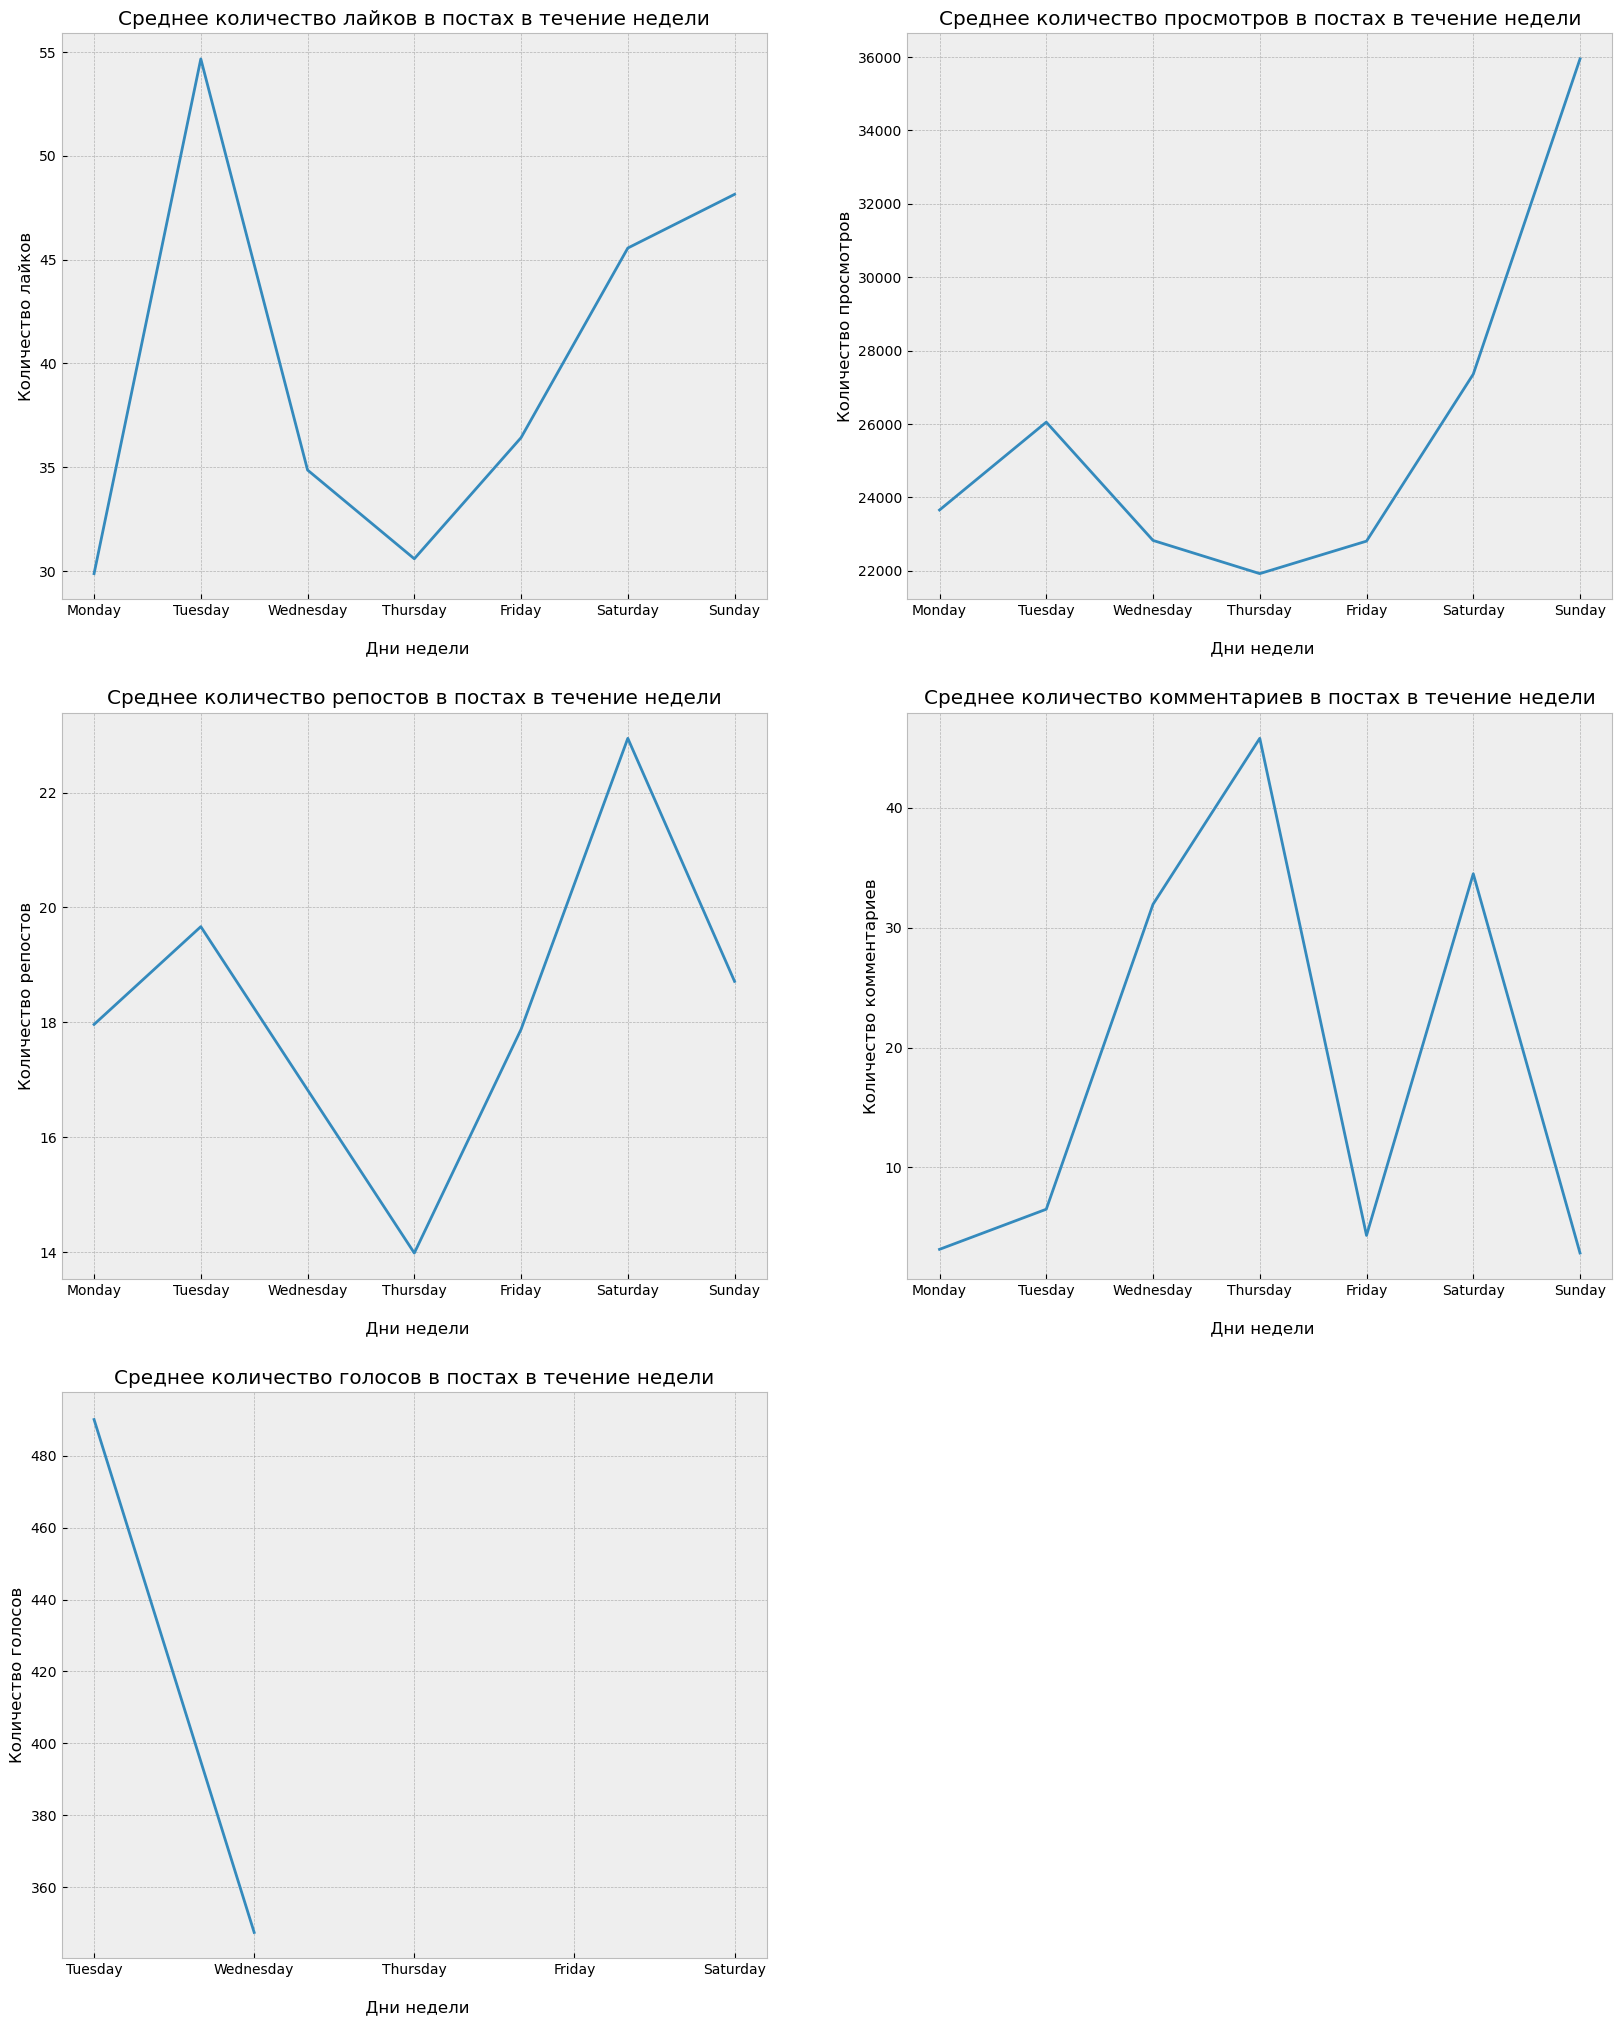

In [199]:
fig = plt.figure(figsize=(20,25))
ax = fig.add_subplot(3,2,1)
ax.plot(data_days.index, data_days.likes)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество лайков')
plt.title('Среднее количество лайков в постах в течение недели')
ax = fig.add_subplot(3,2,2)
ax.plot(data_days.index, data_days.views)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество просмотров')
plt.title('Среднее количество просмотров в постах в течение недели')
ax = fig.add_subplot(3,2,3)
ax.plot(data_days.index, data_days.reposts)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество репостов')
plt.title('Среднее количество репостов в постах в течение недели')
ax = fig.add_subplot(3,2,4)
ax.plot(data_days.index, data_days.comments)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество комментариев')
plt.title('Среднее количество комментариев в постах в течение недели')
ax = fig.add_subplot(3,2,5)
ax.plot(data_days.index, data_days.votes)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество голосов')
plt.title('Среднее количество голосов в постах в течение недели')
plt.show()

In [200]:
# Удельные показатели активности пользователей. Средняя доля каждой метрики на один просмотр поста

data_days_spec = data_days.div(data_days['views'], axis=0)*100
del data_days_spec['views']
data_days_spec.reindex(weekdays)

,likes,reposts,comments,votes
day_of_week,,,,
Monday,0.126285,0.075950,0.013380,NaN
Tuesday,0.209869,0.075502,0.025000,1.881146
Wednesday,0.152735,0.073718,0.139998,1.522508
Thursday,0.139535,0.063804,0.208944,NaN
Friday,0.159707,0.078401,0.018966,NaN
Saturday,0.166533,0.083876,0.126118,1.793073
Sunday,0.133929,0.052062,0.007948,NaN


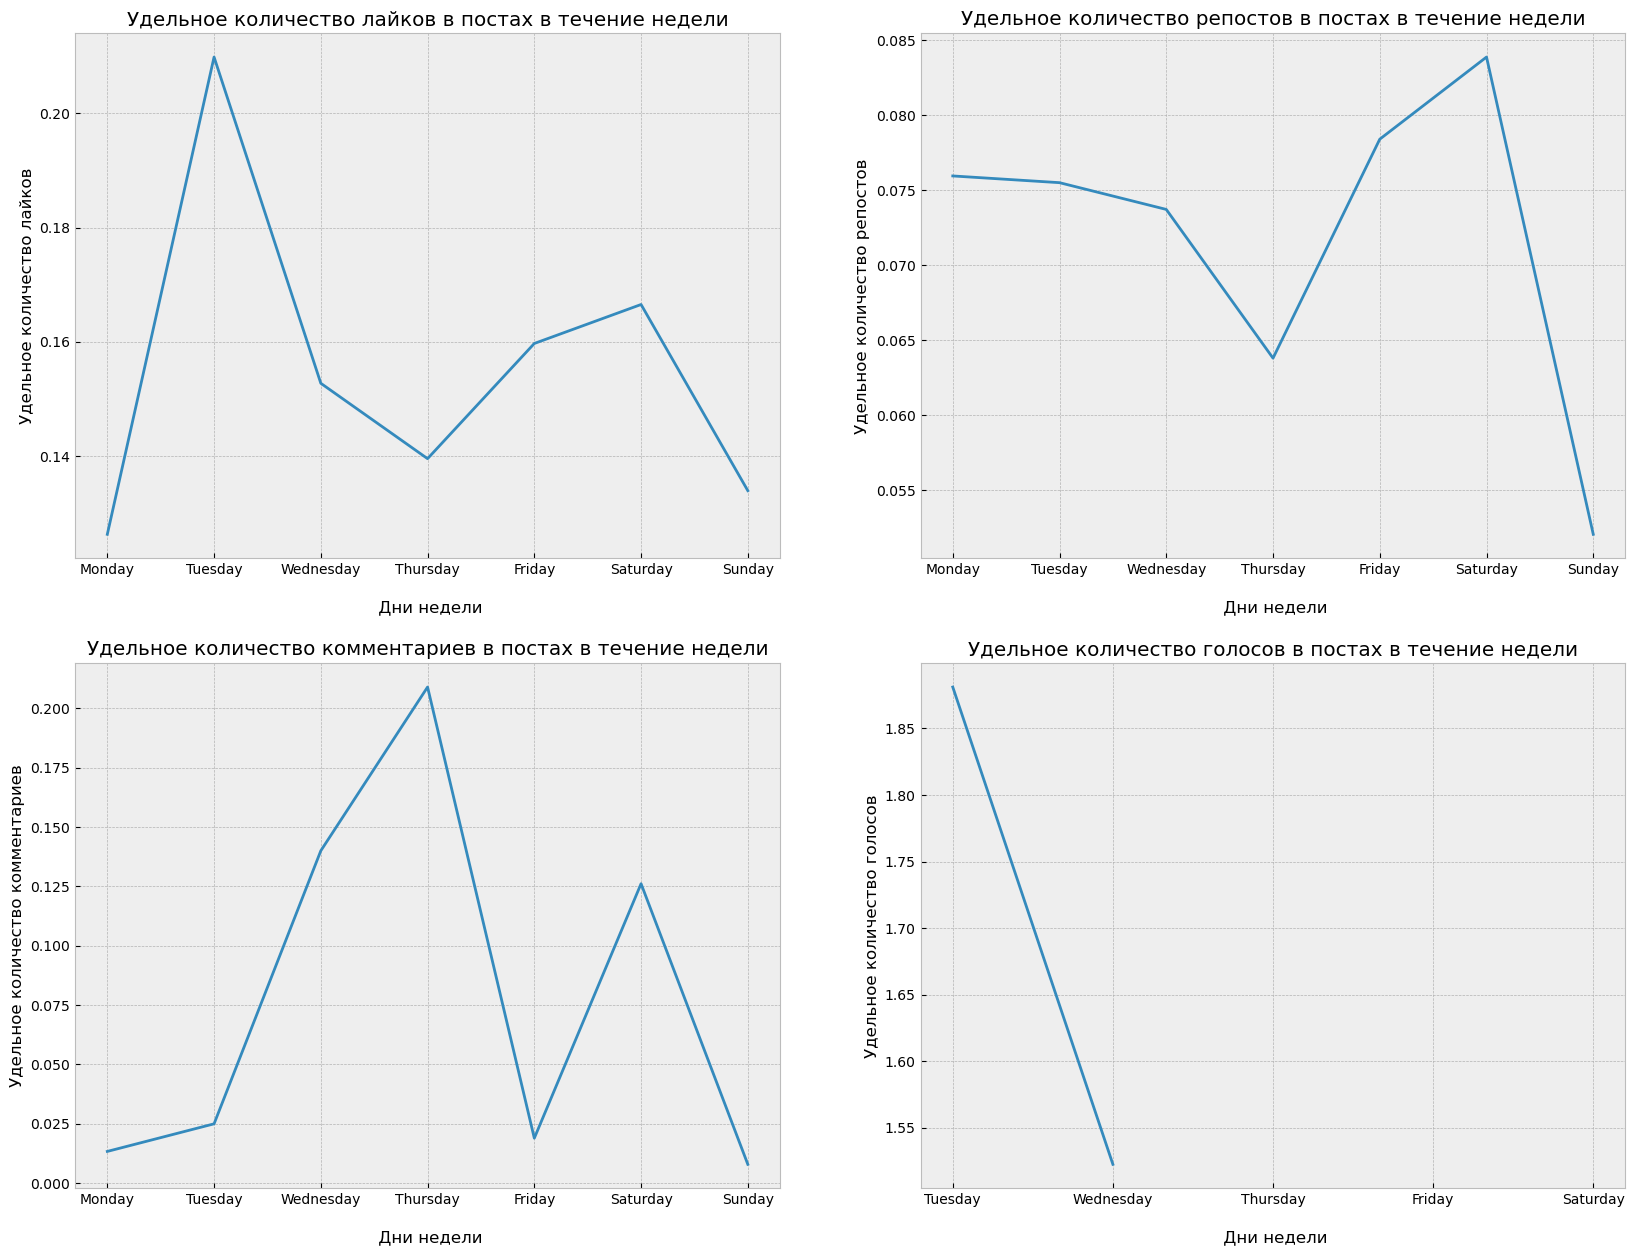

In [201]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(2,2,1)
ax.plot(data_days_spec.index, data_days_spec.likes)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Удельное количество лайков')
plt.title('Удельное количество лайков в постах в течение недели')
ax = fig.add_subplot(2,2,2)
ax.plot(data_days_spec.index, data_days_spec.reposts)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Удельное количество репостов')
plt.title('Удельное количество репостов в постах в течение недели')
ax = fig.add_subplot(2,2,3)
ax.plot(data_days_spec.index, data_days_spec.comments)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Удельное количество комментариев')
plt.title('Удельное количество комментариев в постах в течение недели')
ax = fig.add_subplot(2,2,4)
ax.plot(data_days_spec.index, data_days_spec.votes)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Удельное количество голосов')
plt.title('Удельное количество голосов в постах в течение недели')
plt.show()

## Вывод:
* Графики удельных и абсолютных средних значений метрик активности в течение недели примерно одинаковы.

* На графике абсолютных значений просмотров постов наблюдается, что в четверг имеется наименьшая активность пользователей. Далее просмотры растут до максимального значения в восресенье и снова падают до низкого уровня в понедельник. Небольшой пик активности также наблюдается во вторник.

* График абсолютных значений репостов имеет характерные пики во вторник и субботу, минимум в четверг.

* График абсолютных значений репостов имеет характерные пики во четверг и субботу, минимум в понедельник, пятницу и воскресенье.

* На графике голосов максимальное значение метрики достигается во вторник.

# Аналитика по часам

In [223]:
# Добавляем в датасет столбец со значениями часов в момент публикаций постов

data['hour_post'] = list(map(lambda x: x.hour, data.date))

In [228]:
# Создадим датасет с будними днями и выходными
workdays = weekdays[:-2]
weekends = weekdays[-2:]
data_workdays = data[data['day_of_week'].isin(workdays)] 
data_weekends = data[data['day_of_week'].isin(weekends)] 

In [225]:
data_hours = data_workdays[['likes', 'views', 'reposts', 'comments', 'votes', 'hour_post']]\
    .groupby('hour_post')\
    .mean()

# Удельные показатели активности пользователей. Каждая метрика в завсисмости от каждой 1000 просмотров данной публикации

data_workdays_spec = data_hours[['likes','comments','reposts']].div(data_hours.views, axis=0)*1000
data_workdays_spec['views'] = data_hours['views']
data_workdays_spec

,likes,comments,reposts,views
hour_post,,,,
10,1.649624,0.179289,1.032167,23872.100000
11,1.558386,0.158390,0.784913,24179.404255
12,1.242306,0.193616,0.647232,21089.816667
13,1.373485,0.152609,0.682906,24955.936170
14,1.257651,0.315707,0.687309,21468.600000
15,1.479712,0.288110,0.601395,25535.857143
16,1.499434,2.983544,0.814551,21208.000000
17,2.624412,0.310158,0.722172,27942.769231
18,1.692796,4.174681,0.709740,21952.612903


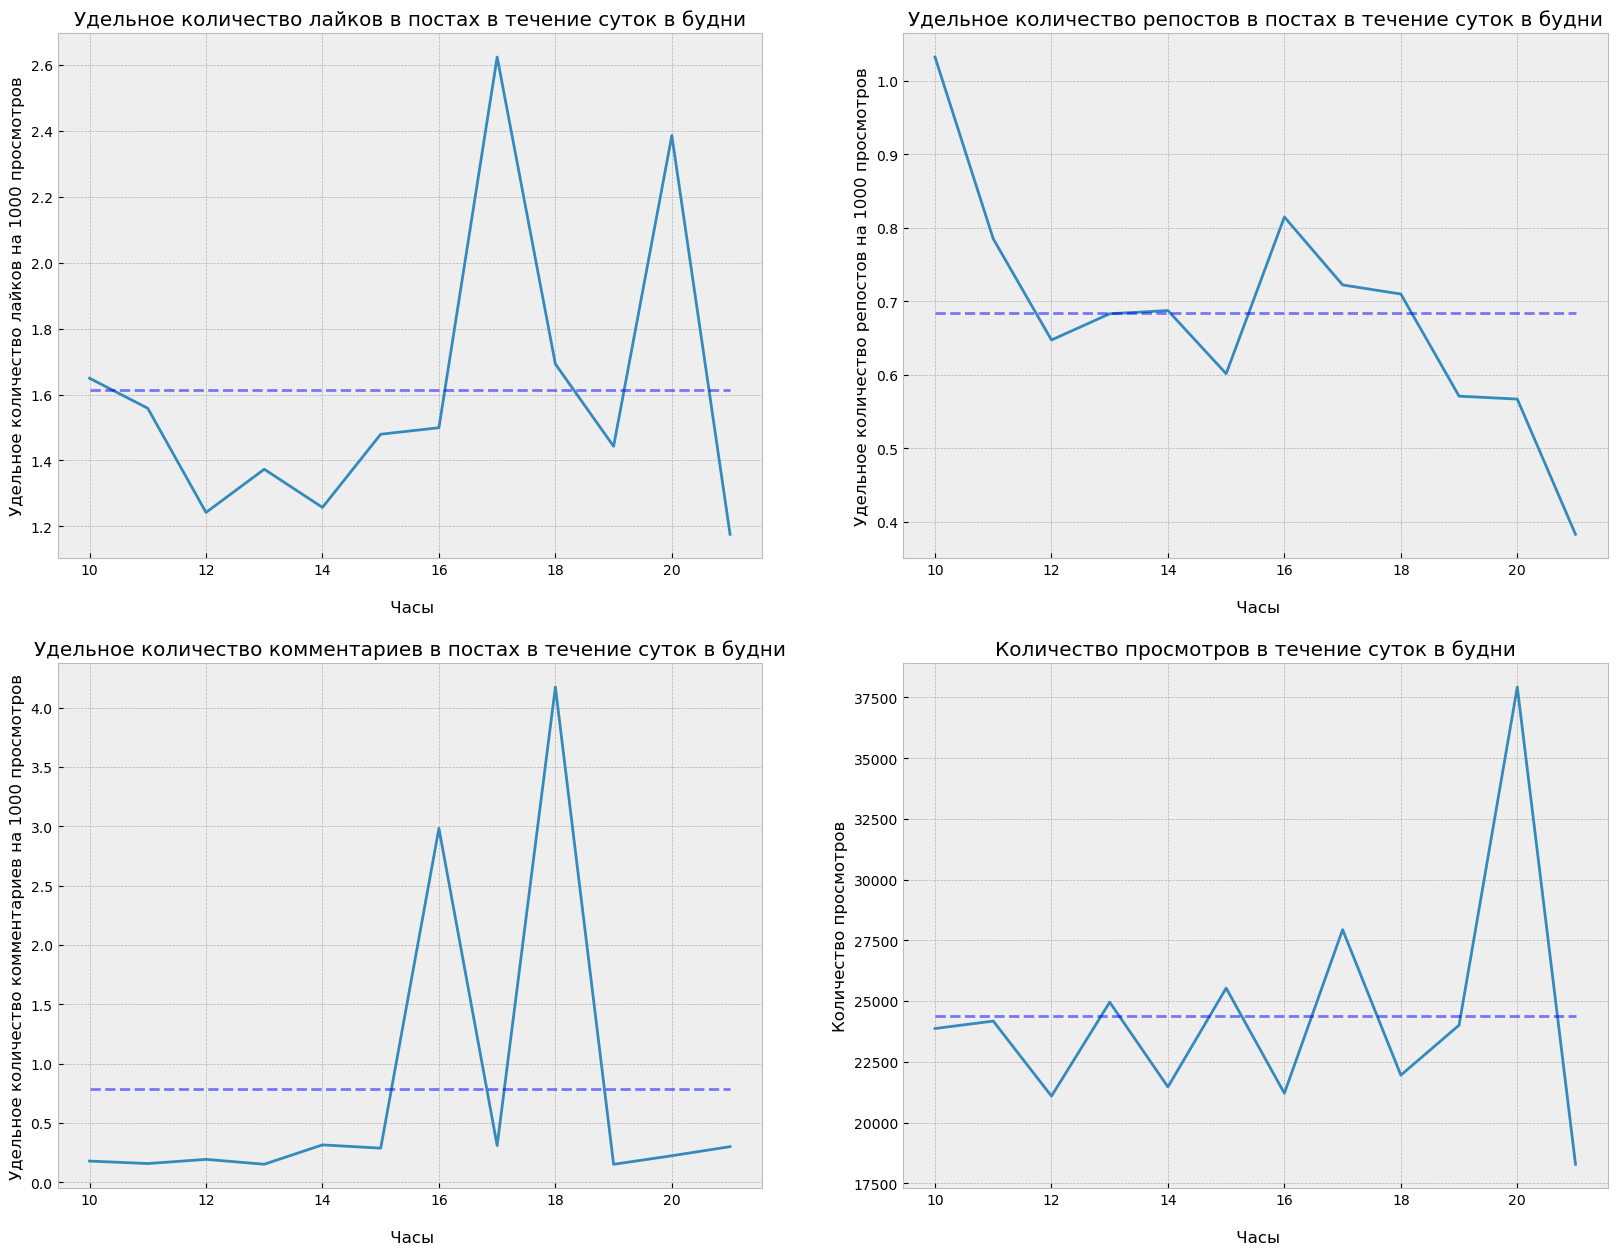

In [226]:
# Построим графики распределения удельных значений активностей пользователей в течение суток в будние дни

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(2,2,1)
ax.plot(data_workdays_spec.index, data_workdays_spec.likes)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество лайков на 1000 просмотров')
plt.title('Удельное количество лайков в постах в течение суток в будни')
plt.hlines(data_workdays_spec.likes.mean(), data_workdays_spec.index.min(),data_workdays_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax = fig.add_subplot(2,2,2)
ax.plot(data_workdays_spec.index,data_workdays_spec.reposts)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество репостов на 1000 просмотров')
plt.title('Удельное количество репостов в постах в течение суток в будни')
plt.hlines(data_workdays_spec.reposts.mean(), data_workdays_spec.index.min(),data_workdays_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax = fig.add_subplot(2,2,3)
ax.plot(data_workdays_spec.index, data_workdays_spec.comments)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество комментариев на 1000 просмотров')
plt.title('Удельное количество комментариев в постах в течение суток в будни')
plt.hlines(data_workdays_spec.comments.mean(), data_workdays_spec.index.min(),data_workdays_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax = fig.add_subplot(2,2,4)
ax.plot(data_workdays_spec.index, data_workdays_spec.views)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Количество просмотров')
plt.title('Количество просмотров в течение суток в будни')
plt.hlines(data_workdays_spec.views.mean(),data_workdays_spec.index.min(),data_workdays_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
plt.show()

In [229]:
data_hours = data_weekends[['likes', 'views', 'reposts', 'comments', 'votes', 'hour_post']]\
    .groupby('hour_post')\
    .mean()

# Удельные показатели активности пользователей. Каждая метрика в завсисмости от каждой 1000 просмотров данной публикации

data_weekends_spec = data_hours[['likes','comments','reposts']].div(data_hours.views, axis=0)*1000
data_weekends_spec['views'] = data_hours['views']
data_weekends_spec

,likes,comments,reposts,views
hour_post,,,,
10,1.651048,0.271589,0.957285,33807.727273
11,1.379076,0.093017,0.545969,35323.857143
12,1.710544,0.904426,0.275260,16953.666667
13,1.660013,9.770960,0.441269,23795.000000
16,1.362759,0.227126,0.681379,13208.500000


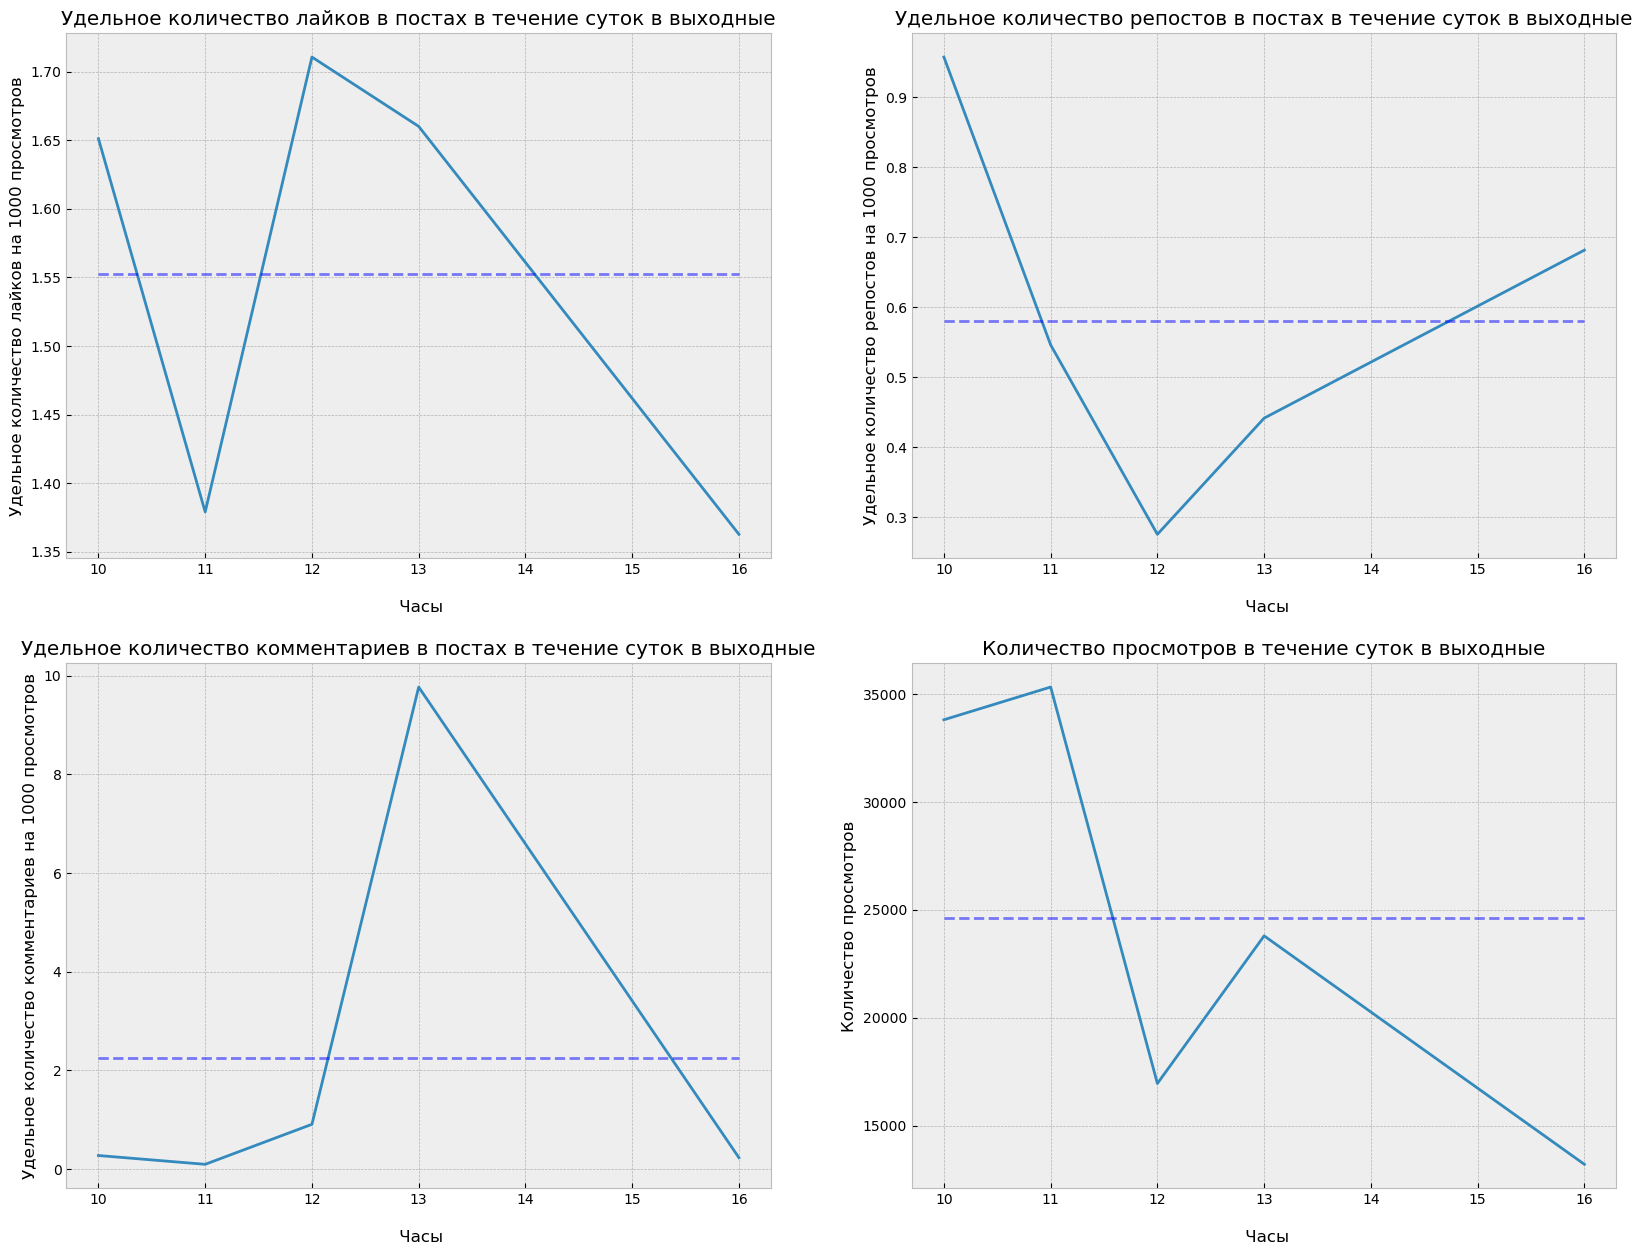

In [232]:
# Построим графики распределения удельных значений активностей пользователей в течение суток в выходные дни

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(2,2,1)
ax.plot(data_weekends_spec.index, data_weekends_spec.likes)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество лайков на 1000 просмотров')
plt.title('Удельное количество лайков в постах в течение суток в выходные')
plt.hlines(data_weekends_spec.likes.mean(), data_weekends_spec.index.min(),data_weekends_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax = fig.add_subplot(2,2,2)
ax.plot(data_weekends_spec.index,data_weekends_spec.reposts)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество репостов на 1000 просмотров')
plt.title('Удельное количество репостов в постах в течение суток в выходные')
plt.hlines(data_weekends_spec.reposts.mean(), data_weekends_spec.index.min(),data_weekends_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax = fig.add_subplot(2,2,3)
ax.plot(data_weekends_spec.index, data_weekends_spec.comments)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество комментариев на 1000 просмотров')
plt.title('Удельное количество комментариев в постах в течение суток в выходные')
plt.hlines(data_weekends_spec.comments.mean(), data_weekends_spec.index.min(),data_weekends_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax = fig.add_subplot(2,2,4)
ax.plot(data_weekends_spec.index, data_weekends_spec.views)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Количество просмотров')
plt.title('Количество просмотров в течение суток в выходные')
plt.hlines(data_weekends_spec.views.mean(),data_weekends_spec.index.min(),data_weekends_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
plt.show()

## Вывод:
В __будни__
* Количество просмотров меняется переодически, возможно это связано со временем перерывов на работе/учебе, когда у пользователей есть время на просмотр соц сетей. Максимальное количество приходится на 20.00, когда пользователи возвращаются домой и имеют возможность отдохнуть. Также выше среднего показателя в 5 часов вечера, когда у большинства пользователей заканчиваются рабочие часы.
* Максимальное удельное количество лайков приходится на 5 и 8 вечера, что соотносится на распределнию просмотров по времени.
* Максимальное количество репостов в утренние часы с 10 с последующим спадом и локальным максимумом в 4 вечера.
* Распределение комментариев по часам имеет два характерных максимума в 4 и 6 часов вечера.

В __выходные__
* Максимальное количество просмотров приходится на утро 10-11, далее спадает в течении дня с небольшим пиком в 13.
* Удельное количество лайков максимально утром в 10 и в обед 12-13
* Максимальное удельное количество репостов приходится на утро в 10 и вечер в 8. Имеет ярко выраженный минимум в 12.
* Распределение удельного количества комментариев имеет ярко выраженный пик в 13 и далее постепенно спадает.




# Аналитика контента

In [235]:
# Типы медиавложений и их сочетания в публикациях

set(' '.join(i) for i in data.attachments)

{'doc',
 'link',
 'photo',
 'photo link',
 'photo poll',
 'photo video',
 'poll',
 'video',
 'video poll'}

In [237]:
# Преоразование записей в удобный вид
data['attachments'] = list(map(lambda x: ' '.join(x), data.attachments))

In [240]:
# Создание датасета с удельными величинами активности пользователей относительно просмотров

data_att = data[['likes', 'views', 'reposts', 'comments', 'attachments']].groupby('attachments').mean()
data_att = data_att.div(data_att['views']/1000, axis=0).round(2)
del data_att['views']
data_att.sort_values('likes', ascending=False, inplace=True)
data_att

,likes,reposts,comments
attachments,,,
video,1.77,0.50,0.23
photo,1.57,0.81,0.88
photo link,1.52,0.68,0.84
photo video,1.35,0.34,0.08
photo poll,1.28,0.60,0.83
link,1.23,0.63,0.68
video poll,1.02,0.38,0.00
poll,0.99,0.10,1.65
doc,0.63,0.11,0.04


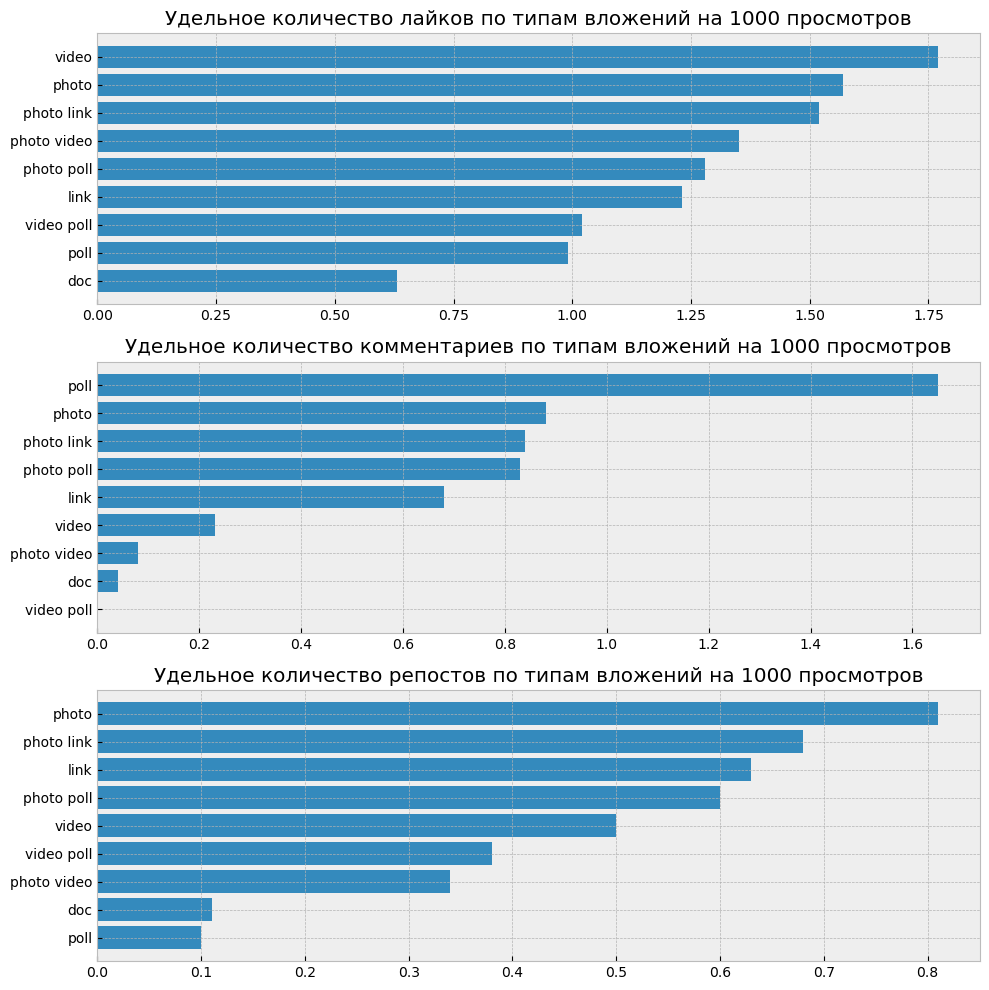

In [247]:
# Построим графики удельного количества лайков, комментариев и репостов для всех прикреплений
%matplotlib inline
plt.style.use('bmh')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(3,1,1)
ax.barh(data_att.sort_values('likes',ascending=True).index, data_att.sort_values('likes',ascending=True).likes)
ax.set_title('Удельное количество лайков по типам вложений на 1000 просмотров')
ax = fig.add_subplot(3,1,2)
ax.barh(data_att.sort_values('comments',ascending=True).index, data_att.sort_values('comments',ascending=True).comments)
ax.set_title('Удельное количество комментариев по типам вложений на 1000 просмотров')
ax = fig.add_subplot(3,1,3)
ax.barh(data_att.sort_values('reposts',ascending=True).index, data_att.sort_values('reposts',ascending=True).reposts)
ax.set_title('Удельное количество репостов по типам вложений на 1000 просмотров')
fig.tight_layout()
plt.show()

## Вывод:
## 1.
### - __Наибольшее__ удельное количество __лайков__ собирают медиавложения:
* video
* photo
* photo link

### - __Наименьшее__ удельное количество __лайков__ собирают медиавложения:

* video poll
* poll
* doc

## 2.
### - __Наибольшее__ удельное количество __комментариев__ собирают медиавложения:
* poll
* photo
* photo link

### - __Наименьшее__ удельное количество __комментариев__ собирают медиавложения:

* video poll
* doc
* photo video

## 3.
### - __Наибольшее__ удельное количество __репостов__ собирают медиавложения:
* photo
* photo link
* link

### - __Наименьшее__ удельное количество __репостов__ собирают медиавложения:

* poll
* doc
* photo video

# Рекомендации для SMM отдела

* В ходе выполнения аналитики над собранными данными, одной из рекомендаций к сотрудникам SMM-отдела хотелось бы отнести большее количество хештегов и более точное написание хештегов, для более качественного анализа рубрик постов вдальнейшем.

* Наиболее популярные рубрики у пользователей те, которые содержат в себе информацию о наиболее популярных в настоящее время образовательных направлениях. Большее поличество комментариев собирают рубрики с анонсами мероприятий, а также рубрики, где описаны успешные истории людей или анонсы мероприятий с известными личностями.

* Пользователи паблика более всего просматривают посты утром выходные дни и вечером В будние дни. В выходны пользоваетли наиболее активны в обеденные часы с 12 до 14. В будни пользователи наиболее активны ближе к вечеру в 16-17 и 20.00. Поэтому самые интересные и полезные пупликации стоит размещать конце рабочего дня.

* Пользователи ставят большее количество лайков в медиавложениях содержащих файлы привлекающие внимание - видео, фото. Самыми комментируемыми постами являются публикации с голосованиями, и прикрепленными фото. Чаще всего пользователи делятся постами с фотографиями, и ссылками.